## Nearest neighbors

## Part I

In [1]:
import numpy as np
import os
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

# Load the numpy .npz file
with np.load(os.path.join('data', 'cifar4-train.npz'), allow_pickle=False) as data:
    cifar4_data = dict(data.items())
    
print('Data loaded')
print('It is a dictionary with keys:', list(cifar4_data.keys()))

Data loaded
It is a dictionary with keys: ['pixels', 'overfeat', 'labels', 'names', 'allow_pickle']


In [2]:
X_features = cifar4_data['overfeat']
X_pixels = cifar4_data['pixels']
y = cifar4_data['labels']

print('X features shape:',X_features.shape)
print('X pixels shape:',X_pixels.shape)
print('y shape:', y.shape)

X features shape: (5000, 4096)
X pixels shape: (5000, 3072)
y shape: (5000,)


In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Create the StandardScaler
scaler = StandardScaler()

# Create the PCA
pca = PCA(n_components=164)

# Create k-NN classifier
knn = KNeighborsClassifier(algorithm='brute')


# Create the pipeline
pipe = Pipeline([('scaler', scaler),
                 ('pca',pca),
                 ('knn', knn)])

In [4]:
# Splitting the data
from sklearn.model_selection import train_test_split

# Split data
X_overfeat_train, X_overfeat_test, X_pixels_train, X_pixels_test, y_train, y_test = train_test_split(X_features,
                                                                                                     X_pixels,
                                                                                                     y,
                                                                                                     train_size=4000,
                                                                                                     test_size=1000,
                                                                                                     random_state=0,
                                                                                                     stratify=y)

X_train_s, X_val, y_train_s, y_val = train_test_split(X_overfeat_train,
                                                  y_train,
                                                  train_size=3200,
                                                  test_size=800,
                                                  random_state=0,
                                                  stratify=y_train)


# checking the shapes
print('X_overfeat_train:', X_overfeat_train.shape, X_overfeat_train.dtype)
print('X_overfeat_test:', X_overfeat_test.shape, X_overfeat_test.dtype)
print('X_pixels_train:', X_pixels_train.shape, X_pixels_train.dtype)
print('X_pixels_test:', X_pixels_test.shape, X_pixels_test.dtype)
print('y_train:', y_train.shape, y_train.dtype)
print('y_test:', y_test.shape, y_test.dtype)

print('X_train_s:', X_train_s.shape, X_train_s.dtype)
print('X_val:', X_val.shape, X_val.dtype)
print('y_train_s:', y_train_s.shape, y_train_s.dtype)
print('y_val:', y_val.shape, y_val.dtype)

X_overfeat_train: (4000, 4096) float32
X_overfeat_test: (1000, 4096) float32
X_pixels_train: (4000, 3072) uint8
X_pixels_test: (1000, 3072) uint8
y_train: (4000,) int64
y_test: (1000,) int64
X_train_s: (3200, 4096) float32
X_val: (800, 4096) float32
y_train_s: (3200,) int64
y_val: (800,) int64


In [5]:
pipe.fit(X_train_s, y_train_s)

# Evaluate on validation set
accuracy = pipe.score(X_val, y_val)

# Print accuracy
print('k-nearest neighbors accuracy: {:.3f}'.format(accuracy))

k-nearest neighbors accuracy: 0.729


Tune **k** and **distance metric (L1 and L2)** using Grid Search

In [6]:
# Define a set of reasonable values
k_values = np.arange(5, 105, 5)
distance_types = [1,2]

# Save accuracy on validation set
validation_scores = []

# Grid search
for k in k_values:
    for d in distance_types:
        # Set hyperparameters
        pipe.set_params(knn__n_neighbors = k, knn__p = d)
        
        # Fit a k-NN classifier
        pipe.fit(X_train_s, y_train_s)
        
        # Evaluate on test set
        accuracy = pipe.score(X_val, y_val)
        
        # Save accuracy
        validation_scores.append({
            'n neighbors': k,
            'distance metric': d,
            'validation accuracy': accuracy
        })
        
# Create DataFrame with test scores
scores_df = pd.DataFrame(validation_scores)

# Top five scores
scores_df.sort_values(by='validation accuracy', ascending=False).head()

,distance metric,n neighbors,validation accuracy
13,2,35,0.77625
10,1,30,0.77125
25,2,65,0.77125
19,2,50,0.77125
31,2,80,0.77125


In [7]:
# Best combination
idx_max = scores_df.loc[scores_df['validation accuracy'].idxmax()]

print('Top accuracy on validation set:',idx_max[2],
      ' with k:',idx_max[1],
      ' with distance metric:',idx_max[0])

Top accuracy on validation set: 0.77625  with k: 35.0  with distance metric: 2.0


Fit the k-NN classifier with the tuned parameters to the entire train data and evaluate the accuracy on the test set.

In [8]:
# Create k-NN classifier
knn = KNeighborsClassifier(n_neighbors=35,algorithm='brute',p=2)

# Create the pipeline and fit it to training data
pipe.fit(X_overfeat_train, y_train)

# Evaluate on test set
accuracy = pipe.score(X_overfeat_test, y_test)

# Print accuracy
print('k-nearest neighbors accuracy: {:.3f}'.format(accuracy))

k-nearest neighbors accuracy: 0.767


## Part II

For the second task, pick an image from the test set and plot its 10 nearest neighbors from the train one.

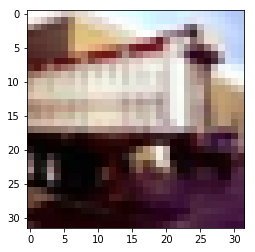

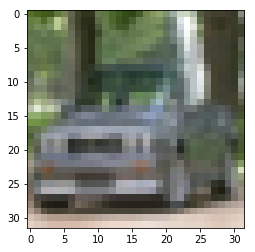

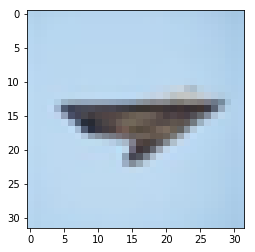

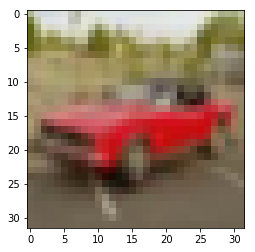

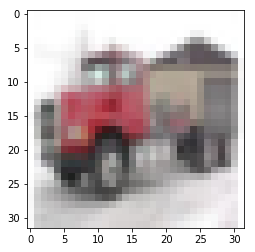

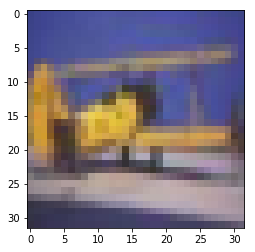

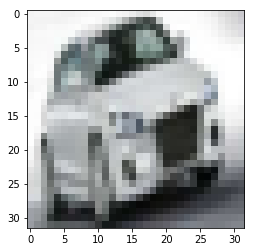

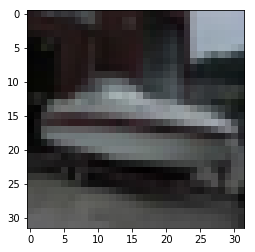

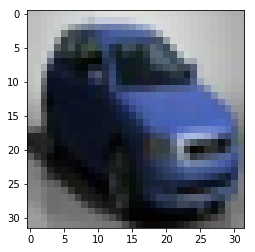

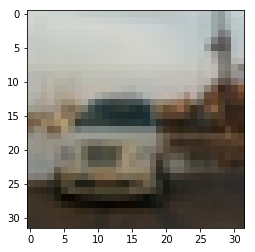

In [10]:
# Select image
sample_img = X_overfeat_test[1].reshape(1, -1)

# Get the 10 nearest neighbors
sample_img_preprocessed = pipe.named_steps['pca'].transform(pipe.named_steps['scaler'].transform(sample_img))
dist, ind = pipe.named_steps['knn'].kneighbors(sample_img_preprocessed, n_neighbors=10)

# Plot the images
for idx in range(0,10):
    plt.imshow((X_pixels_train[idx].reshape(32, 32, 3))/255)
    plt.show()

Can you reuse the best parameters from cell 7 when evaluating the test accuracy in cell 8 i.e. values from idx_max? According to grid search, 50 is the optimal k value, but you use 35 when evaluating the test accuracy in cell 8.

There is an issue in cell 37 with the indexes in the for loop when plotting the nearest neighbors. Can you fix it and verify that the images are visually similar to the test one by plotting your  sample_img test image?